In [1]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# tools for applying bundle adjustment to a temporal sequence of satellite images
import bundle_adjust.ba_timeseries as ba_timeseries

# Display and interface settings (just for the notebook interface)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Load scene

In [2]:
coal_loader = {'geotiff_dir': '/home/carlo/dsms-timeseries-for-roger/RB_ZAF_0001/RB_ZAF_0001_images',
               's2p_configs_dir': '/home/carlo/dsms-timeseries-for-roger/RB_ZAF_0001/RB_ZAF_0001_s2p',
               'rpc_src': 's2p_configs',
               'output_dir': 'exp/coal',
               'ba_method': 'ba_global',
               'timeline_indices': '3',
               'reconstruct_scene': True,
               'aoi_geojson': None,
               'compute_aoi_masks': True,
               'use_aoi_masks_to_equalize_crops': False}

from bundle_adjust import data_loader
data_loader.save_dict_to_json(coal_loader, 'coal_ba_config.json')

In [3]:
scene = ba_timeseries.Scene('coal_ba_config.json')
scene.display_aoi()

#############################################################

Loading scene from coal_ba_config.json

-------------------------------------------------------------
Configuration:
    - images_dir:      /home/carlo/dsms-timeseries-for-roger/RB_ZAF_0001/RB_ZAF_0001_images
    - s2p_configs_dir: /home/carlo/dsms-timeseries-for-roger/RB_ZAF_0001/RB_ZAF_0001_s2p
    - rpc_src:         s2p_configs
    - output_dir:      exp/coal
-------------------------------------------------------------

Defining aoi from s2p config.json files... 541 / 541 done

Number of acquisition dates: 85 (from 2019-06-08 to 2020-05-06)
Number of images: 560
The aoi covers a total of 1.03 squared km:

#############################################################




Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [ ]:
# save aoi
import pickle
pickle_out = open('exp/skysat_coal_singledate/aoi.pickle','wb')
pickle.dump(scene.aoi_lonlat, pickle_out)
pickle_out.close()

### Select date(s) of the scene to adjust

In [4]:
# 0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16 contain no errors

timeline_indices = [0, 3, 6]  #[0, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]

#timeline_indices =timeline_indices[:5]

scene.get_timeline_attributes(timeline_indices, ['datetime', 'n_images', 'id'])

index  |  datetime             |  n_images  |  id             
______________________________________________________________

0      |  2019-06-08 07:53:52  |  5         |  20190608_075352
3      |  2019-06-17 07:51:38  |  9         |  20190617_075138
6      |  2019-06-27 07:48:21  |  7         |  20190627_074821
______________________________________________________________

                                  21 total                    




In [69]:
scene.tracks_config = {'s2p': False,
                       'matching_thr': 0.6,
                       'use_masks': False,
                       'filter_pairs': True,
                       'max_kp': 9000,
                       'optimal_subset': False,
                       'K': 30,
                       'continue': True,
                       'tie_points': False}

### Bundle Adjustment

In [19]:
scene.run_sequential_bundle_adjustment(timeline_indices, n_previous=1, reset=True, verbose=False)

Chosen 3 dates of the timeline to bundle adjust:
(1) 2019-06-08 07:53:52 --> 5 views
(2) 2019-06-17 07:51:38 --> 9 views
(3) 2019-06-27 07:48:21 --> 7 views



Running bundle ajustment sequentially, each date aligned with 1 previous date(s) !
(1) 2019-06-08 07:53:52 adjusted in 10 seconds, 727 (3.06, 0.498)
(2) 2019-06-17 07:51:38 adjusted in 39 seconds, 2471 (27.8, 0.943)
(3) 2019-06-27 07:48:21 adjusted in 43 seconds, 2945 (26.814, 0.9)



TOTAL TIME: 00:01:32.00





In [20]:
scene.run_global_bundle_adjustment(timeline_indices, reset=True, verbose=False)

#scene.timeline_instances_diagram(timeline_indices, scene.ba_pipeline, neighbors=1)
#scene.compare_timeline_instances([0], [3], scene.ba_pipeline)

Chosen 3 dates of the timeline to bundle adjust:
(1) 2019-06-08 07:53:52 --> 5 views
(2) 2019-06-17 07:51:38 --> 9 views
(3) 2019-06-27 07:48:21 --> 7 views



Running bundle ajustment all at once !
All dates adjusted in 75 seconds, 5519 (1.992, 0.637)

TOTAL TIME: 00:01:15.00





In [177]:
scene.tracks_config['L2'] = True
scene.tracks_config['verbose local'] = False

scene.run_out_of_core_bundle_adjustment(timeline_indices, reset=True, verbose=True,
                                        parallelize=False, tie_points=False)

Chosen 1 dates of the timeline to bundle adjust:
(1) 2019-06-17 07:51:38 --> 9 views


########################
 Running out of core BA 
########################

(1) 2019-06-17 07:51:38, 3316, (1.102, 0.459) 

##############################################################
- Local sweep done in 54 seconds (avg per date: 54.00 s)
##############################################################

Loading 9 image projection matrices / 9

Loading 2 image rpcs / 2

Loading 2 image crops / 2

Approximating RPCs as Perspective projection matrices
2 projection matrices / 2 (0 err)
Done!

Building feature tracks - satellite scenario - using opencv SIFT

Parameters:
      use_masks:    False
      matching_thr: 0.6



Running feature detection...


...done in 0.016551852226257324 seconds

Computing pairs to match...

1 / 1 pairs suitable to match
1 / 1 pairs suitable to triangulate
0 new pairs to be matched

...done in 0.0046116653829813 seconds

Skipping matching (no pairs to match)

PAIRS TO TRIA

Displaying feature track with index 1674, length 2

3D location (initial)  : [ 4739640.08660615  2968883.91071231 -3056092.65575934]
3D location (after BA) : [ 4739645.14412064  2968962.5722331  -3056085.09600835] 

 ----> Real 2D loc in im 5  (yellow) =  [327.67877197 521.175354  ]
 ----> Proj 2D loc in im 5  before BA (red) =  [327.20694361 521.07047655]
 ----> Proj 2D loc in im 5  after  BA (green) =  [327.33387727 521.09787873]
              Reprojection error beofre BA: 0.576705814810623
              Reprojection error after  BA: 0.4223699811785764


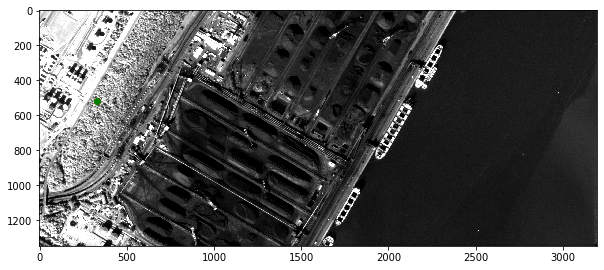

 ----> Real 2D loc in im 6  (yellow) =  [513.11187744 288.77380371]
 ----> Proj 2D loc in im 6  before BA (red) =  [513.40603875 288.84814851]
 ----> Proj 2D loc in im 6  after  BA (green) =  [513.3247928  288.82674521]
              Reprojection error beofre BA: 0.36850610656091476
              Reprojection error after  BA: 0.2658568650148254


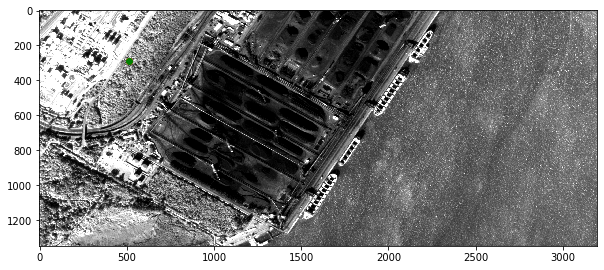

Mean reprojection error before BA: 0.4726059606857689
Mean reprojection error after BA: 0.3441134230967009


In [71]:
scene.ba_pipeline.visualize_feature_track()

image 1, mean abs reproj error before BA: 1.0259
image 1, mean abs reproj error after  BA: 0.5057


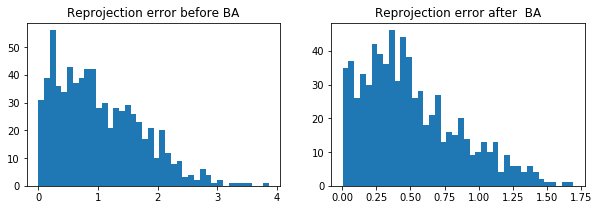

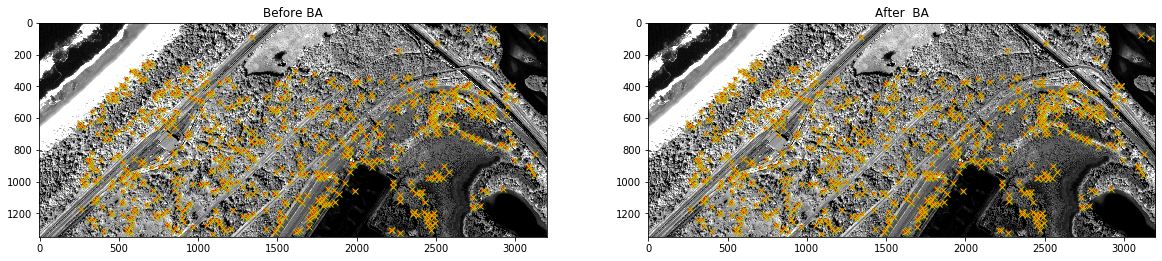

In [72]:
scene.ba_pipeline.analyse_reproj_err_particular_image(1, plot=True)

In [ ]:
scene.display_crops()

Found 9000 keypoints in image 0 and 9000 keypoints in image 1


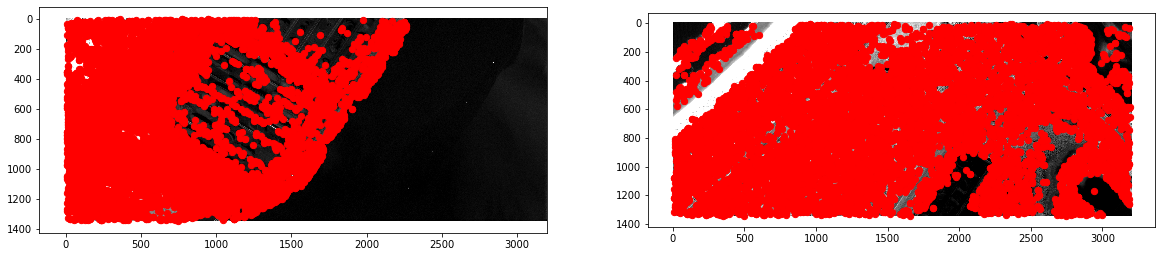

In [73]:
from feature_tracks import ft_utils

ft_utils.plot_features_stereo_pair(0, 1, scene.ba_pipeline.features, scene.ba_pipeline.input_seq)

In [ ]:
from feature_tracks import ft_utils

ft_utils.plot_pairwise_matches_stereo_pair(1, 3, scene.ba_pipeline.features,
                                           scene.ba_pipeline.pairwise_matches, scene.ba_pipeline.input_seq)

In [ ]:
from feature_tracks import ft_utils

ft_utils.plot_track_observations_stereo_pair(0, 1, scene.ba_pipeline.C,  scene.ba_pipeline.input_seq)

----- CONNECTIVITY GRAPH: 21 edges


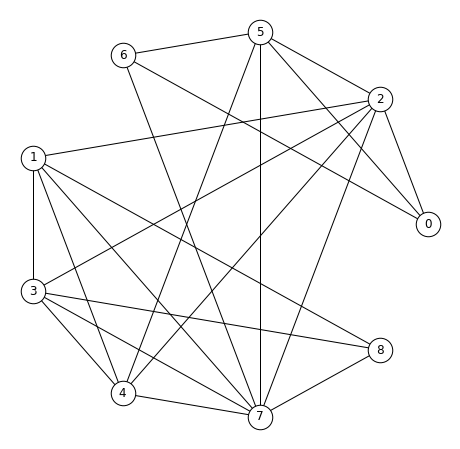

----- CONNECTIVITY GRAPH: 13 edges


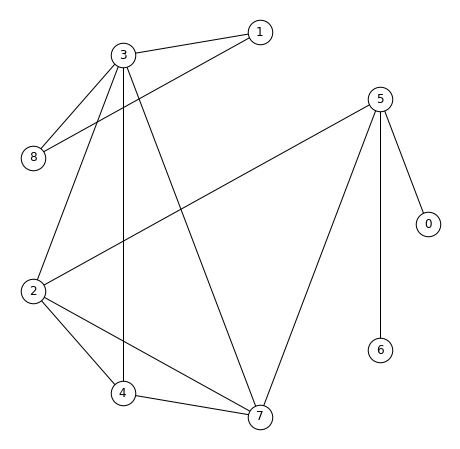

array([[  0.,   0.,  52.,   0.,   0., 349.,  85.,   0.,   0.],
       [  0.,   0.,  86., 657.,  77.,   0.,   0.,  66., 150.],
       [ 52.,  86.,   0., 144., 650., 172.,  30., 171.,   0.],
       [  0., 657., 144.,   0., 154.,   0.,   0., 287., 631.],
       [  0.,  77., 650., 154.,   0.,  95.,  18., 655.,   0.],
       [349.,   0., 172.,   0.,  95.,   0., 391., 134.,   0.],
       [ 85.,   0.,  30.,   0.,  18., 391.,   0.,  66.,   0.],
       [  0.,  66., 171., 287., 655., 134.,  66.,   0.,  88.],
       [  0., 150.,   0., 631.,   0.,   0.,   0.,  88.,   0.]])

In [74]:
from bundle_adjust import ba_utils

ba_utils.plot_connectivity_graph(scene.ba_pipeline.C, 50, save_pgf=False)

ba_utils.plot_connectivity_graph(scene.ba_pipeline.C, 100, save_pgf=False)

In [ ]:
scene.display_crops()

In [ ]:
scene.ba_pipeline.visualize_feature_track()

In [ ]:
scene.ba_pipeline.save_feature_tracks_as_svg(scene.dst_dir)

In [11]:
output_file = '../ames_test3/pairs_to_triangulate.txt'

with open(output_file, "w") as f:
    for pair in scene.ba_pipeline.pairs_to_triangulate:
        fname_i = '/ames_test3/' + ba_timeseries.get_id(scene.ba_pipeline.myimages[pair[0]]) + '.tif'
        fname_j = '/ames_test3/' + ba_timeseries.get_id(scene.ba_pipeline.myimages[pair[1]]) + '.tif'
        f.write('{} {}\n'.format(fname_i, fname_j))

print('done writing', output_file)

done writing ../ames_test3/pairs_to_triangulate.txt


In [13]:
print(scene.ba_pipeline.pairs_to_triangulate)

print(len(scene.ba_pipeline.pairs_to_triangulate))

[(4, 7), (1, 3), (2, 6), (5, 6), (1, 4), (0, 5), (2, 3), (3, 7), (2, 5), (2, 7), (5, 7), (3, 8), (0, 6), (1, 8), (1, 7), (2, 4)]
16


In [40]:
aoi_from_image_footprints_lonlat

{'coordinates': [[[32.039734, -28.839558999999994],
   [32.039734, -28.805949000000002],
   [32.067238, -28.805949000000002],
   [32.067238, -28.839558999999994]]],
 'type': 'Polygon',
 'center': [32.05348600000001, -28.822753999999996]}

In [45]:
rois_geojson = []
for x in scene.ba_pipeline.footprints:
    vertices = (np.array(x['poly'].boundary.coords.xy).T)[:-1,:]
    output_aoi = {'coordinates': [vertices.tolist()], 'type': 'Polygon'}
    output_aoi['center'] = np.mean(output_aoi['coordinates'][0][:4], axis=0).tolist()
    rois_geojson.append(output_aoi)

from IS18.utils import zonestring_from_lonlat
utm_zone = zonestring_from_lonlat(scene.aoi_lonlat['center'][0], scene.aoi_lonlat['center'][1])
aoi_from_image_footprints_utm = ba_utils.combine_aoi_borders(rois_geojson)
aoi_from_image_footprints_lonlat = ba_utils.utm_aoi_to_lonlat_aoi(aoi_from_image_footprints_utm, utm_zone)

ba_utils.display_rois_over_map([aoi_from_image_footprints_lonlat], zoom_factor = 14)

print('--lon-lat-limit <min_lon min_lat max_lon max_lat>')

lons = np.array(aoi_from_image_footprints_lonlat['coordinates'])[0][:,0]
lats = np.array(aoi_from_image_footprints_lonlat['coordinates'])[0][:,1]
min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

print('--lon-lat-limit {:.6f} {:.6f} {:.6f} {:.6f}'.format(min_lon, min_lat, max_lon, max_lat))

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

--lon-lat-limit <min_lon min_lat max_lon max_lat>
--lon-lat-limit 32.039734 -28.839559 32.067238 -28.805949


# Reconstruct scene

### Compute s2p DSMs with corrected RPCs

In [6]:
test = scene.ba_pipeline.pts_3d_ba.copy()

from bundle_adjust import ba_utils
lat, lon, alt = ba_utils.ecef_to_latlon_custom(test[:,0], test[:,1], test[:,2])

lat_max, lat_min = np.percentile(lat, 95), np.percentile(lat, 5)
lon_max, lon_min = np.percentile(lon, 95), np.percentile(lon, 5)
alt_max, alt_min = np.percentile(alt, 95), np.percentile(alt, 5)

print('lat max-min:', lat_max, lat_min)
print('lon max-min:', lon_max, lon_min)
print('alt max-min:', alt_max, alt_min)

lat max-min: -28.81300803489607 -28.833640370564616
lon max-min: 32.06497099660345 32.044649708055424
alt max-min: 86.01419500494376 65.32545121666044


In [21]:
ba_method = 'ba_global'
#ba_method = 'ba_sequential'

for t_idx in timeline_indices:
    scene.reconstruct_date(t_idx, ba_method, verbose=False)


###################################################################################
Reconstructing scene at time 2019-06-08 07:53:52
Number of dsms to compute: 4
Output directory: exp/coal/ba_sequential/4D
Timeline id: 20190608_075352
###################################################################################

Running s2p...

Computed 4 dsms / 4 (0 err)

Merging dsms...

Done!



###################################################################################
Reconstructing scene at time 2019-06-17 07:51:38
Number of dsms to compute: 10
Output directory: exp/coal/ba_sequential/4D
Timeline id: 20190617_075138
###################################################################################

Running s2p...

Computed 10 dsms / 10 (0 err)

Merging dsms...

Done!



###################################################################################
Reconstructing scene at time 2019-06-27 07:48:21
Number of dsms to compute: 8
Output directory: exp/coal/ba_sequential/4D
Timeline

In [10]:
scene.project_pts3d_adj_onto_dsms(timeline_indices, ba_method)

successfully created exp/coal/ba_sequential/4D/pts3d_adj/20190608_075352.svg
successfully created exp/coal/ba_sequential/4D/pts3d_adj/20190617_075138.svg
successfully created exp/coal/ba_sequential/4D/pts3d_adj/20190627_074821.svg


In [26]:
scene.close_small_holes(timeline_indices, ba_method, imscript_bin_dir='bin')

done computing cdsms for date 2019-06-08 07:53:52
done computing cdsms for date 2019-06-17 07:51:38
done computing cdsms for date 2019-06-27 07:48:21


In [42]:
scene.compute_stat_per_date(timeline_indices, ba_method, stat='avg', use_cdsms=True)


###################################################################################
Computing avg for specific date...
  - complete_dsm_fname: exp/coal/ba_sequential/4D/dsms/20190608_075352.tif
  - tile_size: 500
###################################################################################


Clipping dsms...
4 dsms / 4
Done!

exp/coal/ba_sequential/4D/metrics/avg_per_date/20190608_075352.tif

Done!

done computing avg for date 2019-06-08 07:53:52

###################################################################################
Computing avg for specific date...
  - complete_dsm_fname: exp/coal/ba_sequential/4D/dsms/20190617_075138.tif
  - tile_size: 500
###################################################################################


Clipping dsms...
10 dsms / 10
Done!

exp/coal/ba_sequential/4D/metrics/avg_per_date/20190617_075138.tif

Done!

done computing avg for date 2019-06-17 07:51:38

#################################################################################

In [51]:
scene.compute_3D_statistics_over_time(timeline_indices, ba_method)


Computing 4D statistics of the timeseries! Chosen dates:
2019-06-17 07:51:38


ValueError: need at least one array to concatenate

In [45]:
x = np.array([2.3, 6.1, 0.3, 7.8])

In [50]:
np.std(x)

2.973529048117741

In [49]:
np.sqrt(np.mean(x**2) - np.mean(x)**2)

2.973529048117741